# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer, StandardScaler
import time 
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''


'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# see the atructure 
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# azdias shape
azdias.shape

(891221, 85)

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
# see the structure 
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
# feet_info shape
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.


**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
#calculate the number of missing data

natural_missing_data = azdias.isnull().sum().sum()
print("Number of natural Missing Data before mapping is: {}".format(natural_missing_data))

Number of natural Missing Data before mapping is: 4896838


In [9]:
# calculate the number of missing unknown data

for ind in range(len(feat_info)):
    
    unknown = feat_info.iloc[ind]['missing_or_unknown'] # iloc : indexing by position
    
    unknown = unknown.strip('[')
    
    unknown = unknown.strip(']')
    
    unknown = unknown.split(sep=',')
    
    unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in unknown]
    
    if unknown != ['']:
        azdias = azdias.replace({feat_info.iloc[ind]['attribute']: unknown}, np.nan)



In [10]:
# Identify missing or unknown data values and convert them to NaNs.

print('Total number of missing values is {}'.format(azdias.isnull().sum().sum()))

Total number of missing values is 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_data_per_column =(azdias.isnull().sum()/len(azdias))*100

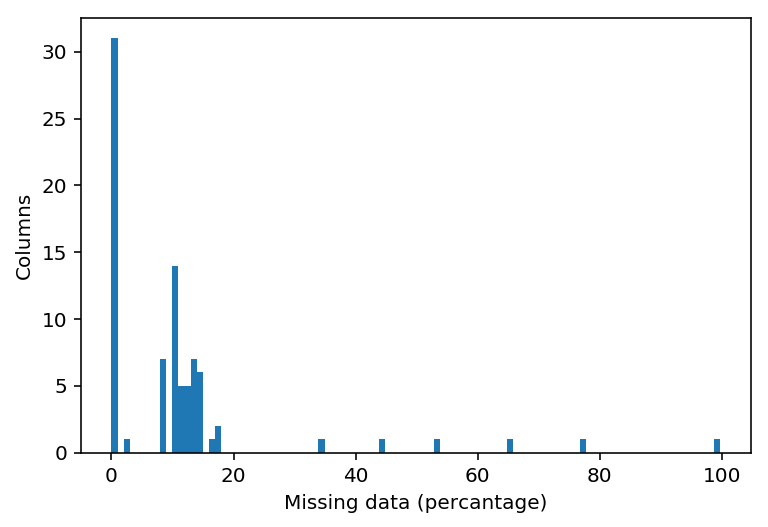

In [12]:
# Investigate patterns in the amount of missing data in each column.
# by drawing a hist the distribution of missing data can be visualised. 

plt.hist(missing_data_per_column, bins=100)
plt.ylabel('Columns')
plt.xlabel('Missing data (percantage)')
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

missing_data = missing_data_per_column[missing_data_per_column > 20]

In [14]:
#indicating the columns which have more than 20 percent missing data
drop = missing_data.index.tolist() #Return a copy of the array data as a (nested) Python list. Data items are converted to the nearest compatible builtin Python type, via the item function.
print('These columns with more than 20 percent missing data:{}'.format(drop))

These columns with more than 20 percent missing data:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [15]:
# drop the columns with more than 20% missing data
azdias = azdias.drop(drop, axis=1)

In [16]:
#visualizign after the dropping 
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?

as can be seen in the above histogram, 6 columns including 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX' have more than 20% missing data, therefore they should be dropped. These columns are considers as outliers. 
the table above showed these 6 columns have been eliminated and now we have 79 columns.


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

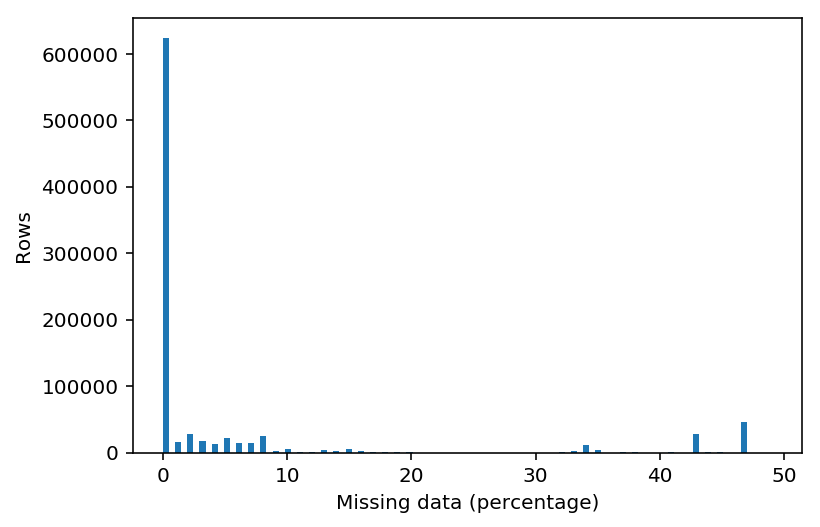

In [17]:
# How much data is missing in each row of the dataset?
# similar to previous one, I will make a histogram in order to observe the missing data in each row
missing_data_per_row =azdias.isnull().sum(axis=1)
plt.hist(missing_data_per_row, bins=100)
plt.ylabel('Rows')
plt.xlabel('Missing data (percentage)')
plt.show()


In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# rows with more than and equal 3 missing values
azdias_many = azdias[azdias.isnull().sum(axis=1) > 3]


# rows with less than 3 missing values 
azdias_few = azdias[azdias.isnull().sum(axis=1) <= 3]
 

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


# first take the values from the columns which have no missing data

no_missing_coloumns = missing_data_per_column[missing_data_per_column == 0].index.tolist()
compare_columns_distribution = no_missing_coloumns[:10]


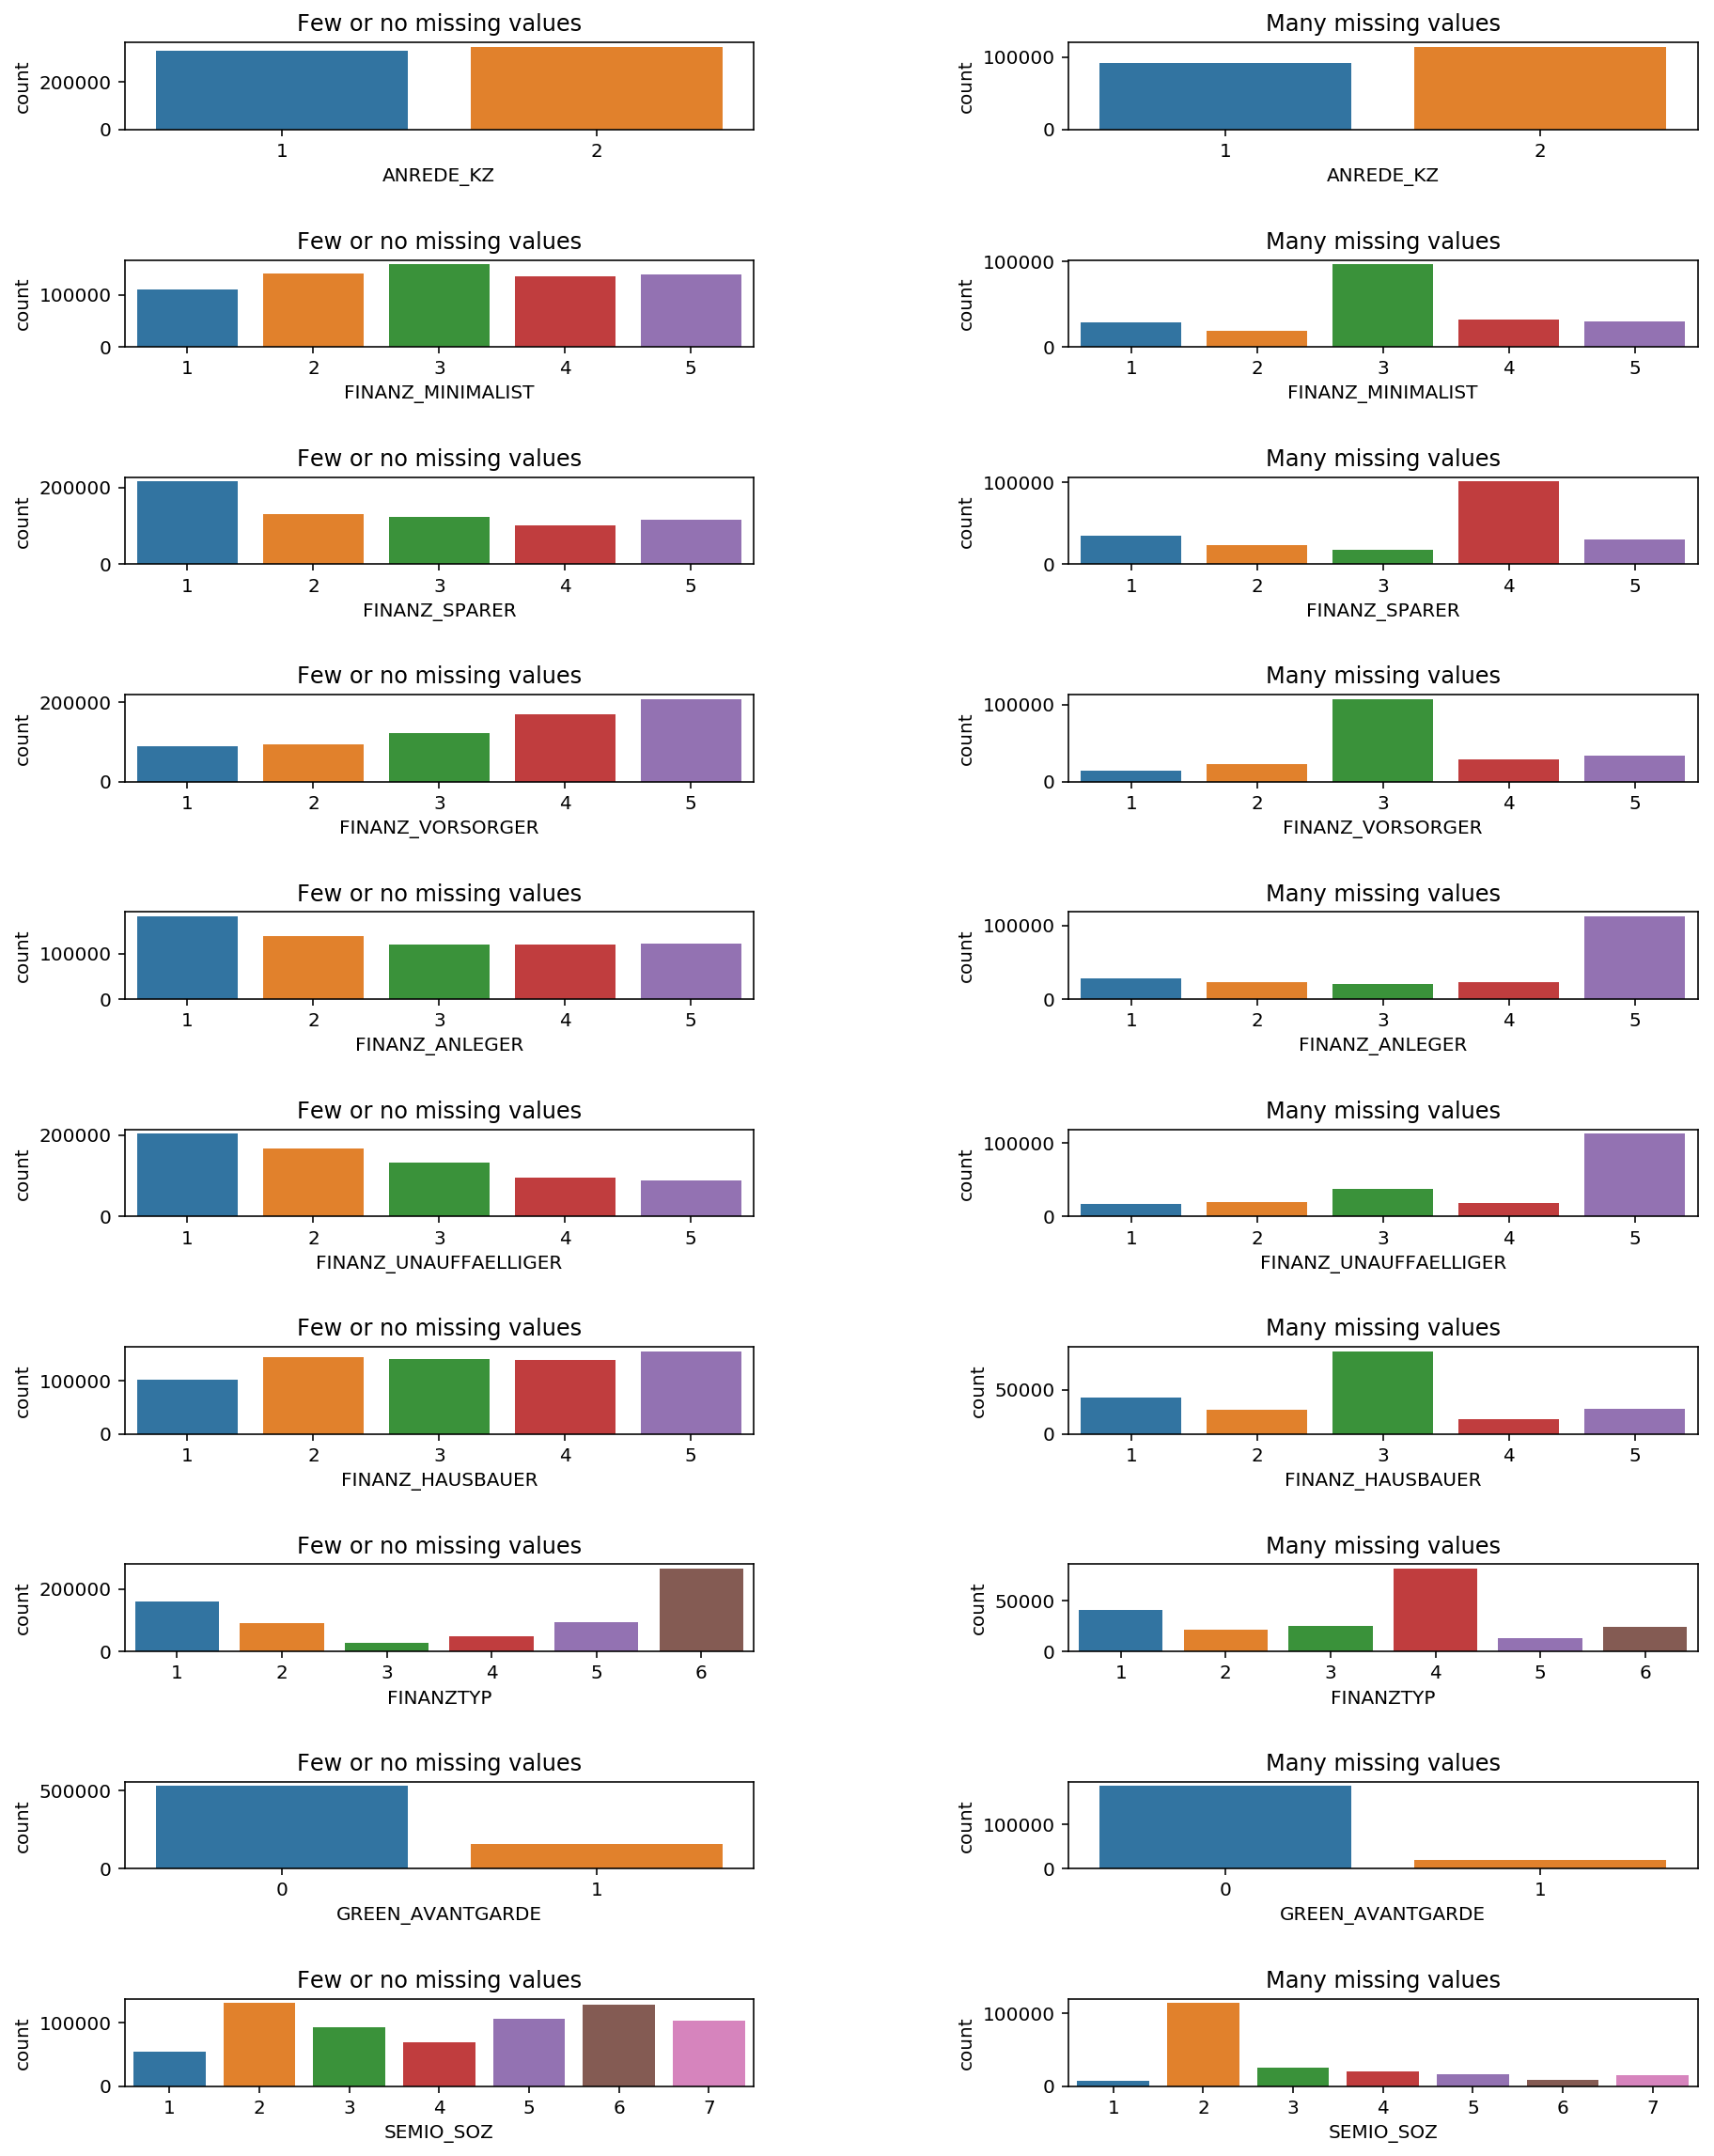

In [20]:
# compare the values between two subsets 

figure, axs = plt.subplots(nrows=len(compare_columns_distribution), ncols=2, figsize = (15,20))

figure.subplots_adjust(hspace = 1.5, wspace=.5)

for i in range(len(compare_columns_distribution)):
    # use seaborn's countplot() function to create a bar chart of code frequencies
    sns.countplot(azdias_few[compare_columns_distribution[i]], ax=axs[i][0])
    #matplotlib's subplot() function to put bar charts for the two subplots side by side.
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(azdias_many[compare_columns_distribution[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Based on the above bar chart for columns and comparison between the distribution on each segment, I can say for gender feature, the distribution between values are quite similar however, for other columns related to individual financial type, household net income ,.. the distributions differ by segment. Based on this visualization, we can say that taking out rows concluding null values will introduce bias. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?

features = list(azdias_few.columns)

feat_info_feature = feat_info[feat_info['attribute'].isin(features)]

amout_of_data_type = feat_info_feature['type'].value_counts()

for i in range(len(amout_of_data_type)):
    print('There are {} {} features.'.format(amout_of_data_type[i], amout_of_data_type.index[i]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 numeric features.
There are 6 mixed features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_columns = feat_info_feature.loc[feat_info['type'] == 'categorical', 'attribute'].values
print(categorical_columns)

['ANREDE_KZ' 'CJT_GESAMTTYP' 'FINANZTYP' 'GFK_URLAUBERTYP'
 'GREEN_AVANTGARDE' 'LP_FAMILIE_FEIN' 'LP_FAMILIE_GROB' 'LP_STATUS_FEIN'
 'LP_STATUS_GROB' 'NATIONALITAET_KZ' 'SHOPPER_TYP' 'SOHO_KZ' 'VERS_TYP'
 'ZABEOTYP' 'GEBAEUDETYP' 'OST_WEST_KZ' 'CAMEO_DEUG_2015' 'CAMEO_DEU_2015']


In [23]:
# seperate binary and multi-level categorical
#seperating multilevel and binary variables
binary_columns= []
multilevel_columns = []

for feature in categorical_columns:
    if (len(azdias_few[feature].unique())==2):
        binary_columns.append(feature)
    elif (len(azdias_few[feature].unique())>2):
        multilevel_columns.append(feature)        


In [24]:

print('Binary features are: {}'.format(binary_columns))
print('Multi-level features are: {}'.format(multilevel_columns))

Binary features are: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level features are: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [25]:
#encode binary columns

for feature in binary_columns:
    print('Unique values for {} are {}'.format(feature, azdias_few[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for SOHO_KZ are [ 1.  0.]
Unique values for VERS_TYP are [ 2.  1.]
Unique values for OST_WEST_KZ are ['W' 'O']


In [26]:
# Re-encode categorical variable(s) to be kept in the analysis.

replacement = {'W': 0, 'O': 1}

azdias_clean = azdias_few.replace({'OST_WEST_KZ':replacement})

In [27]:
# Droping  multi-level columns

for feature in multilevel_columns:
    azdias_clean= azdias_clean.drop(feature, axis=1)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

All of the binary columns including 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ' are preserved however, all multi_level features are dropped.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [28]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_clean['DECADE'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

azdias_clean['MOVEMENT'] = azdias_clean['PRAEGENDE_JUGENDJAHRE']

In [29]:
#define an interval type varaible for decade
decade_var = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

# define a binary (0,1) variable for movement
movement_var = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}


In [30]:
#replace the variables using both decade and movement dictionary
azdias_clean['DECADE'].replace(decade_var, inplace=True)

azdias_clean['MOVEMENT'].replace(movement_var, inplace=True)

In [31]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.(based on the above hint, the two axes 'wealth' and 'life style'have been chosen)
azdias_clean['WEALTH'] = azdias_clean['CAMEO_INTL_2015']

azdias_clean['LIFE_STAGE'] = azdias_clean['CAMEO_INTL_2015']

In [32]:
# breaking up the two-digit codes by their 'tens' and 'ones' place digits into two new ordinal variable 

wealth_var = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_var={'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [33]:
# replace 'wealth_var' and 'life_stage_var' dictionary on the new feature columns

azdias_clean['WEALTH'].replace(wealth_var, inplace=True)
azdias_clean['LIFE_STAGE'].replace(life_stage_var, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Based on the explanation in 1.2.2 intruction, I kept 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' mixed-value features. For enginnering steps: at the beginning two new feature columns with having the initial values of the mixed-value feature column has been created (e.g for  'PRAEGENDE_JUGENDJAHRE', these two features are 'decade' and 'movement'), in the next step, two dictionaries have been created and now we can map the initial feature values to the new feature values (inplace = True).

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [34]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

mixed_value_features = feat_info_feature[feat_info_feature["type"]=="mixed"]["attribute"]

for feature in mixed_value_features:
    azdias_clean.drop(feature, axis=1, inplace=True)

In [35]:
azdias_clean.head()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,5.0,1.0,2.0,2.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [63]:
def clean_data(df):
    
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ind in range(len(feat_info)):
    
        unknown = feat_info.iloc[ind]['missing_or_unknown'] # iloc : indexing by position
    
        unknown = unknown.strip('[')
    
        unknown = unknown.strip(']')
    
        unknown = unknown.split(sep=',')
    
        unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in unknown]
    
        if unknown != ['']:
        
            df_clean = df.replace({feat_info.iloc[ind]['attribute']: unknown}, np.nan)
          
    
    # replace the missing value
    
    for column in df.columns:
        df_clean = df_clean.replace({column: ['XX', 'X']}, np.nan)
        
    # remove selected columns and rows, ...
    #  columns with more than 20 percent missing data:
    columns_20_per_missing = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    #dropping the columns
    df_clean = df_clean.drop(columns_20_per_missing, axis = 1)
    
    #dropping the rows with more than 3 missing values
    df_clean = df_clean[df_clean.isnull().sum(axis=1) <= 3]
    
    # select, re-encode, and engineer column values.
    # re-encode binary variable to be kept in the analysis.
    replacement = {'W': 0, 'O': 1}
    df_clean = df_clean.replace({'OST_WEST_KZ':replacement})

    #dropping the multi-level-feature
    categorical_columns = feat_info_feature[feat_info_feature['type'] == 'categorical']['attribute']
                             
    multilevel_columns = []

    for feature in categorical_columns:
        if (len(azdias_few[feature].unique())>2):
            multilevel_columns.append(feature)    
    
    for feature in multilevel_columns:
        df_clean = df_clean.drop(feature, axis=1)
    
    # engineering the mixed features
    
    df_clean['DECADE'] = df_clean['PRAEGENDE_JUGENDJAHRE']

    df_clean['MOVEMENT'] = df_clean['PRAEGENDE_JUGENDJAHRE']
    
    #define an interval type varaible for decade
    decade_var = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}

    # define a binary (0,1) variable for movement
    movement_var = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    
    #replace the variables using both decade and movement dictionary
    df_clean['DECADE'].replace(decade_var, inplace=True)

    df_clean['MOVEMENT'].replace(movement_var, inplace=True)
    
    df_clean['WEALTH'] = df_clean['CAMEO_INTL_2015']

    df_clean['LIFE_STAGE'] = df_clean['CAMEO_INTL_2015']
    
    # breaking up the two-digit codes by their 'tens' and 'ones' place digits into two new ordinal variable 

    wealth_var = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
                  '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
                  '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_var={'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                    '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                    '51':1, '52':2, '53':3, '54':4, '55':5}
    
    # replace 'wealth_var' and 'life_stage_var' dictionary on the new feature columns

    df_clean['WEALTH'].replace(wealth_var, inplace=True)
    df_clean['LIFE_STAGE'].replace(life_stage_var, inplace=True)
    
    mixed_value_features = feat_info_feature[feat_info_feature["type"]=="mixed"]["attribute"]

    for feature in mixed_value_features:
        df_clean.drop(feature, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_clean  
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [37]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

fill_up_the_missing = Imputer(strategy='most_frequent')  # Imputation transformer for completing missing values.
                                                  #replace missing using the most frequent value along each column. Can be used with strings or numeric data.  

imputing_azdias_clean = pd.DataFrame(fill_up_the_missing.fit_transform(azdias_clean))


In [38]:
imputing_azdias_clean.columns = azdias_clean.columns
imputing_azdias_clean.index = azdias_clean.index

In [39]:
# Apply feature scaling to the general population demographics data.
#initiating
feature_scaling = StandardScaler()
#fit the data for scaling
scaling_azdias_clean = feature_scaling.fit_transform(imputing_azdias_clean)



In [40]:
#final data

scaling_azdias_clean = pd.DataFrame(scaling_azdias_clean, columns=list(imputing_azdias_clean))

In [41]:
scaling_azdias_clean.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.747634,0.975423,-1.523655,1.588878,-1.050212,1.513292,1.048651,1.341142,-0.542999,1.038860,...,0.409122,1.432172,0.564740,-0.187976,-0.133875,0.678924,1.144730,0.542999,1.169744,-1.255608
1,0.193497,0.975423,-1.523655,0.908468,-1.771419,-0.548762,0.320698,1.341142,1.841624,1.038860,...,-0.963869,0.402503,0.564740,-0.187976,-0.133875,-0.799090,1.144730,-1.841624,-0.873113,0.753418
2,0.193497,-1.025197,0.677626,0.228057,0.392200,-1.236113,0.320698,-0.834925,-0.542999,1.038860,...,0.409122,-0.627167,-0.334972,0.816965,0.301888,1.417930,-0.232759,0.542999,0.488792,0.083743
3,-1.747634,0.975423,-0.056134,-1.132765,1.113406,-0.548762,-0.407255,1.341142,-0.542999,1.038860,...,0.409122,1.432172,1.464451,-1.192917,-1.005401,-0.060083,-1.610248,0.542999,1.169744,0.753418
4,-0.777068,0.975423,-1.523655,1.588878,-1.771419,1.513292,1.048651,-0.109569,-0.542999,-0.285764,...,-0.963869,1.432172,1.464451,0.816965,0.301888,-0.060083,0.455986,0.542999,-0.873113,-0.585933


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

For completing the missing value, the 'imputer' has been chosen. The strategy that is used is 'most_frequent' which replace missing using the most frequent value along each column. For scaling the features,the StandardScaler method has been chosen.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data
pca = PCA()
#fit the data 
pca.fit(scaling_azdias_clean)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

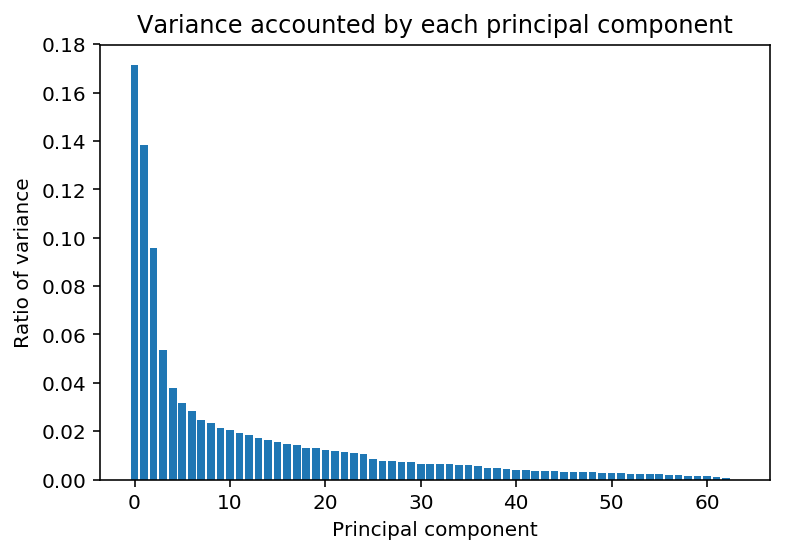

In [43]:
# Investigate the variance accounted for by each principal component.

#explained_variance_ratio_ is percentage of variance explained by each of the selected components. 

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

plt.title("Variance accounted by each principal component")

plt.xlabel("Principal component")

plt.ylabel("Ratio of variance")
plt.show()


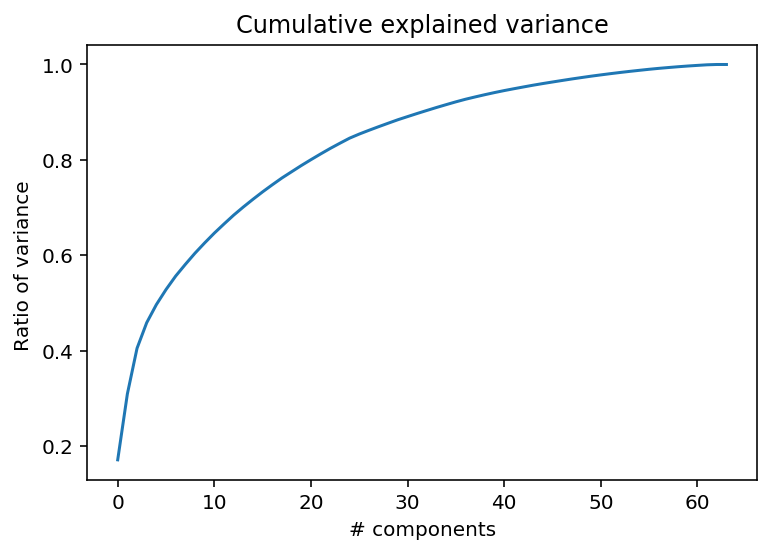

In [44]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')

plt.title("Cumulative explained variance")

plt.xlabel("# components")

plt.ylabel("Ratio of variance ")

plt.show()

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_50 = PCA(n_components=50)

azdias_pca = pca_50.fit_transform(scaling_azdias_clean)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Based on the above plot, as you can seen, afer 50 features, the variance explained levels off and the cumulative explained is more than 0.9 (near 1). Based on this, I am retaining 50 principal components. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [46]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_map_weights(pca, i):
    
    df = pd.DataFrame(pca.components_, columns=list(scaling_azdias_clean.columns))
    map_weight = df.iloc[i].sort_values(ascending=False)
    return map_weight

In [47]:
#for the first principal component

first_pca_weight = pca_map_weights(pca_50, 0)
print (first_pca_weight)


PLZ8_ANTG3               0.220711
PLZ8_ANTG4               0.214165
WEALTH                   0.201747
HH_EINKOMMEN_SCORE       0.199923
ORTSGR_KLS9              0.190927
EWDICHTE                 0.188370
FINANZ_SPARER            0.154826
FINANZ_HAUSBAUER         0.153379
KBA05_ANTG4              0.150497
PLZ8_ANTG2               0.148882
ARBEIT                   0.139579
KBA05_ANTG3              0.135383
ANZ_HAUSHALTE_AKTIV      0.134509
RELAT_AB                 0.129916
SEMIO_PFLICHT            0.122400
SEMIO_REL                0.120072
DECADE                   0.115818
MOVEMENT                 0.111461
SEMIO_TRADV              0.106040
SEMIO_RAT                0.101987
SEMIO_MAT                0.089735
SEMIO_FAM                0.086258
FINANZ_UNAUFFAELLIGER    0.085244
SEMIO_KULT               0.082415
FINANZ_ANLEGER           0.073740
REGIOTYP                 0.061374
OST_WEST_KZ              0.056272
SEMIO_SOZ                0.049426
PLZ8_HHZ                 0.040628
KKK           

In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

second_pca_weight = pca_map_weights(pca_50, 1)
print (second_pca_weight)


ALTERSKATEGORIE_GROB     0.252939
SEMIO_ERL                0.228755
FINANZ_VORSORGER         0.221934
SEMIO_LUST               0.177210
RETOURTYP_BK_S           0.162699
FINANZ_HAUSBAUER         0.124830
SEMIO_KRIT               0.121044
W_KEIT_KIND_HH           0.115419
SEMIO_KAEM               0.113679
PLZ8_ANTG3               0.105631
PLZ8_ANTG4               0.101174
EWDICHTE                 0.100779
ORTSGR_KLS9              0.099729
ANREDE_KZ                0.091042
WEALTH                   0.083804
KBA05_ANTG4              0.078008
ARBEIT                   0.073660
PLZ8_ANTG2               0.071626
RELAT_AB                 0.070655
SEMIO_DOM                0.068838
ANZ_HAUSHALTE_AKTIV      0.068454
HH_EINKOMMEN_SCORE       0.063433
WOHNDAUER_2008           0.054839
KBA05_ANTG3              0.053660
FINANZ_MINIMALIST        0.052308
ANZ_HH_TITEL             0.032066
VERS_TYP                 0.031368
OST_WEST_KZ              0.030104
MOVEMENT                 0.023189
REGIOTYP      

In [49]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
third_pca_weight= pca_map_weights(pca_50, 2)
print (third_pca_weight)


SEMIO_VERT               0.347771
SEMIO_SOZ                0.263247
SEMIO_FAM                0.250498
SEMIO_KULT               0.231953
FINANZ_MINIMALIST        0.157938
RETOURTYP_BK_S           0.116842
FINANZ_VORSORGER         0.100528
W_KEIT_KIND_HH           0.090749
ALTERSKATEGORIE_GROB     0.084443
SEMIO_REL                0.078693
SEMIO_LUST               0.075136
SEMIO_MAT                0.051723
GREEN_AVANTGARDE         0.049770
EWDICHTE                 0.046941
ORTSGR_KLS9              0.046833
PLZ8_ANTG4               0.044875
PLZ8_ANTG3               0.044330
WOHNDAUER_2008           0.035593
ARBEIT                   0.031726
RELAT_AB                 0.030602
PLZ8_ANTG2               0.029972
KBA05_ANTG4              0.027934
ANZ_HAUSHALTE_AKTIV      0.025824
WEALTH                   0.024789
VERS_TYP                 0.021824
ANZ_HH_TITEL             0.014213
OST_WEST_KZ              0.011511
ANZ_TITEL                0.010495
KBA05_ANTG3              0.006882
PLZ8_HHZ      

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

As you can see in below, the first_pca is related to the income and capital, which are weighted positively 

PLZ8_ANTG3               0.220711
PLZ8_ANTG4               0.214165
WEALTH                   0.201747
HH_EINKOMMEN_SCORE       0.199923
ORTSGR_KLS9              0.190927
EWDICHTE                 0.188370
FINANZ_SPARER            0.154826
FINANZ_HAUSBAUER...


However, in below you can see some negative feature weights indicate less wealth and smaller size of family.   

LIFE_STAGE              -0.123520
FINANZ_VORSORGER        -0.124331
INNENSTADT              -0.159287
KONSUMNAEHE             -0.162624
PLZ8_GBZ                -0.163857
KBA05_GBZ               -0.214052
PLZ8_ANTG1              -0.221102
FINANZ_MINIMALIST       -0.221245
KBA05_ANTG1             -0.222708
MOBI_REGIO              -0.238902


The second_pca has some relation with age based on some parameters such as ALTERSKATEGORIE_GROB

The third_pca household income and community unemployment rate. Some strong negative feature weights are HH_EINKOMMEN_SCORE and FINANZ_SPARER and some positive weight such as ARBEIT which indicate the lower unemployment rate and higher household income.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
# Over a number of different cluster counts...

#preform k-means clustering by using sklearn
def k_mean_score(data, n_cluster):
    
    kmeans = KMeans(n_clusters = n_cluster)
    
    model = kmeans.fit(data)
    
    score = np.abs(model.score(data))
    
    return score
    

In [56]:
# run k-means clustering on the data and...
scores = []
k_means_clustering = list(range(1,18))
       
# compute the average within-cluster distances.
for k in k_means_clustering:
    scores.append(k_mean_score(azdias_pca, k))    

Text(0,0.5,'SSE')

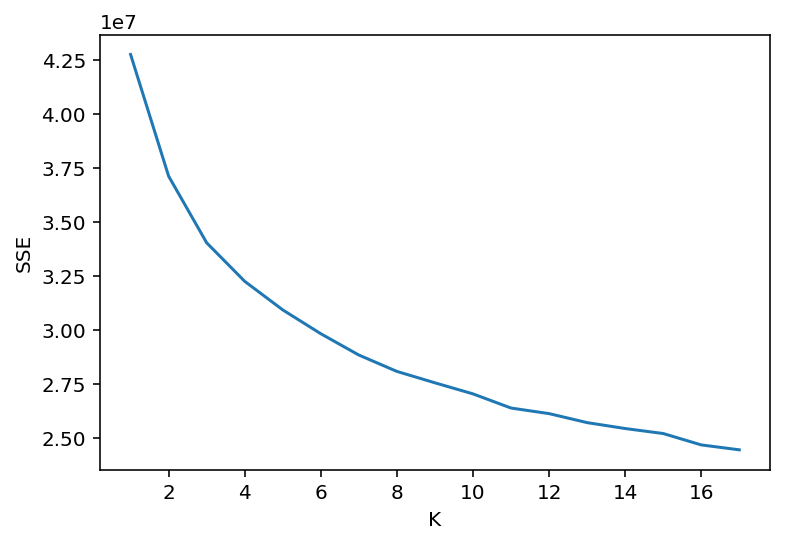

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(k_means_clustering, scores, linestyle='-')

plt.xlabel('K')

plt.ylabel('SSE')

In [59]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans = KMeans(n_clusters = 11)

model_11 = kmeans.fit(azdias_pca)

azdias_pred = model_11.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Regarding to scree plot, it is necessary to fing the elbow and based on the depicted plot, I choose k=11 for segmenting the population 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [60]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [64]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

#first we need to get the clean data 
customers_demographics = clean_data(customers)


In [65]:
# Replacing the missing data 
customers_demographics_imputed = pd.DataFrame(fill_up_the_missing.fit_transform(customers_demographics))
customers_demographics_imputed.columns = customers_demographics.columns
customers_demographics_imputed.index = customers_demographics.index

In [67]:
# Apply preprocessing and feature transformation

# Apply preprocessing and scaling
customers_demographics_scaling = feature_scaling .transform(customers_demographics_imputed)
customers_demographics_scaling = pd.DataFrame(customers_demographics_scaling, columns=list(customers_demographics_imputed))
# PCA transformation
customers_pca = pca_50.transform(customers_demographics_scaling)

In [68]:
# obtaining cluster predictions for the customer demographics data.
customers_pred = model_11.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Clusters')

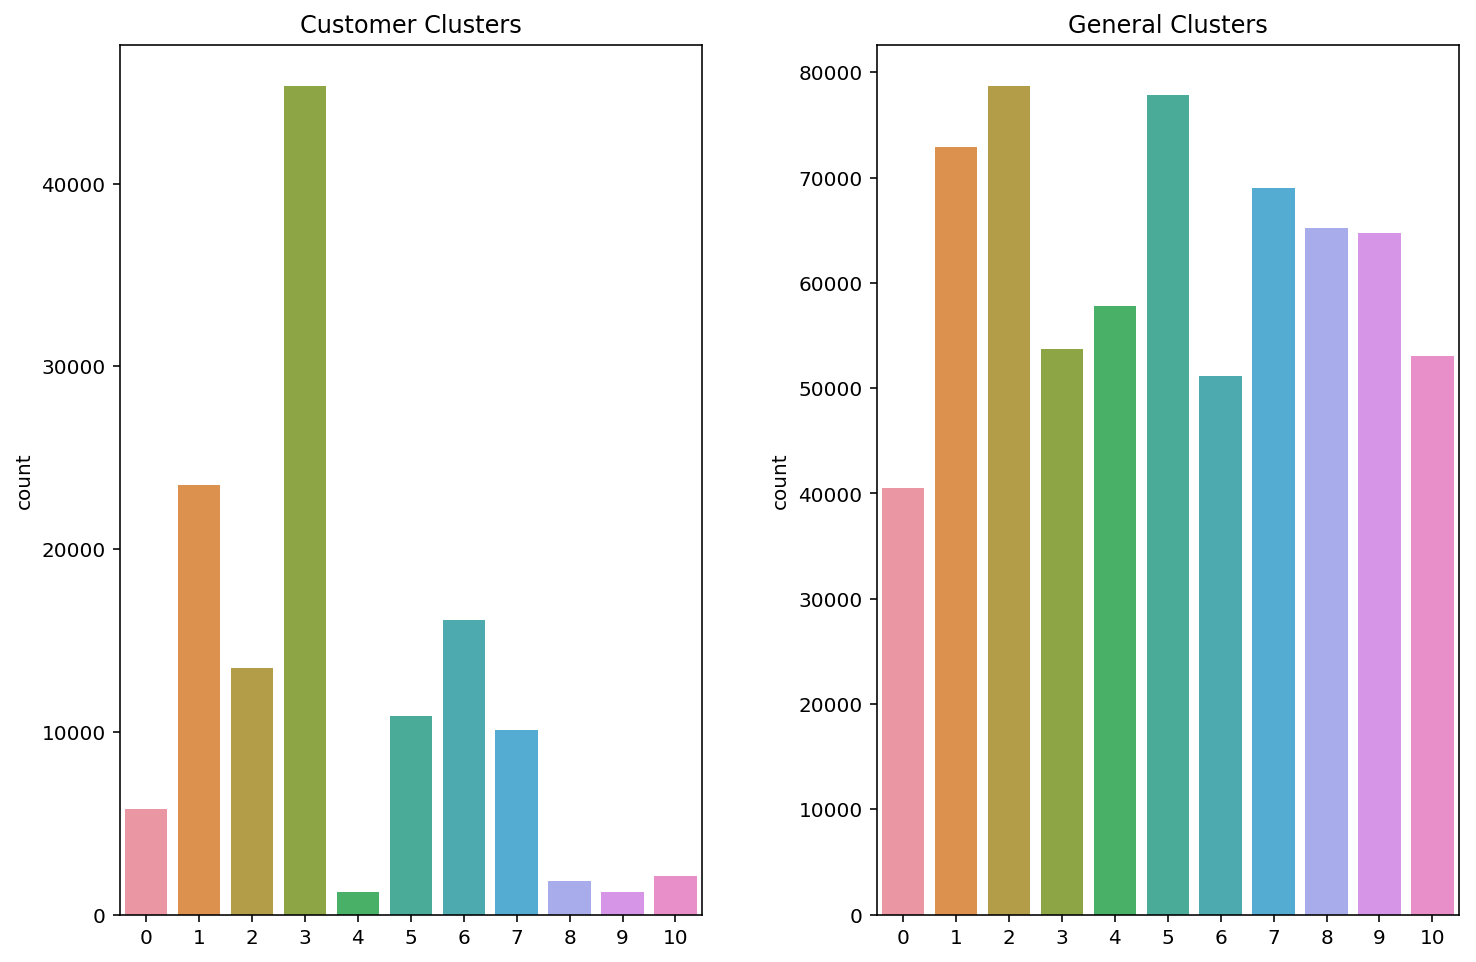

In [69]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (12,8))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customers_pred, ax=axs[0])

axs[0].set_title('Customer Clusters')

sns.countplot(azdias_pred, ax=axs[1])

axs[1].set_title('General Clusters')

In [77]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_3 = feature_scaling.inverse_transform(pca_50.inverse_transform(model_11.cluster_centers_[3]))


In [78]:
overrepresented = pd.Series(data = centroid_3, index = customers_demographics.columns)

In [79]:
overrepresented

ALTERSKATEGORIE_GROB        3.329397
ANREDE_KZ                   1.029500
FINANZ_MINIMALIST           4.770674
FINANZ_SPARER               1.670132
FINANZ_VORSORGER            4.215683
FINANZ_ANLEGER              1.548063
FINANZ_UNAUFFAELLIGER       2.114304
FINANZ_HAUSBAUER            1.943391
GREEN_AVANTGARDE            0.985584
HEALTH_TYP                  2.080003
RETOURTYP_BK_S              3.975384
SEMIO_SOZ                   4.944215
SEMIO_FAM                   4.550955
SEMIO_REL                   3.845906
SEMIO_MAT                   3.877457
SEMIO_VERT                  6.213698
SEMIO_LUST                  5.332059
SEMIO_ERL                   4.081446
SEMIO_KULT                  5.089570
SEMIO_RAT                   2.730372
SEMIO_KRIT                  3.149945
SEMIO_DOM                   3.534664
SEMIO_KAEM                  2.507475
SEMIO_PFLICHT               2.998982
SEMIO_TRADV                 3.224025
SOHO_KZ                     0.008611
VERS_TYP                    1.543775
A

In [80]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_9 = feature_scaling.inverse_transform(pca_50.inverse_transform(model_11.cluster_centers_[9]))


In [81]:
underrepresented = pd.Series(data = centroid_9, index = customers_demographics.columns)

In [82]:
underrepresented

ALTERSKATEGORIE_GROB        1.505666
ANREDE_KZ                   2.012065
FINANZ_MINIMALIST           1.188573
FINANZ_SPARER               4.230302
FINANZ_VORSORGER            2.128895
FINANZ_ANLEGER              4.070005
FINANZ_UNAUFFAELLIGER       3.674617
FINANZ_HAUSBAUER            4.163842
GREEN_AVANTGARDE            0.036234
HEALTH_TYP                  2.178590
RETOURTYP_BK_S              2.386485
SEMIO_SOZ                   3.210216
SEMIO_FAM                   4.015860
SEMIO_REL                   5.483978
SEMIO_MAT                   4.930720
SEMIO_VERT                  2.246898
SEMIO_LUST                  2.623738
SEMIO_ERL                   4.118694
SEMIO_KULT                  4.376862
SEMIO_RAT                   6.505271
SEMIO_KRIT                  5.478275
SEMIO_DOM                   6.486180
SEMIO_KAEM                  6.220673
SEMIO_PFLICHT               6.158891
SEMIO_TRADV                 6.296050
SOHO_KZ                     0.007936
VERS_TYP                    1.442352
A

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


Comparing the customer data to the population data, cluster 3 is overrepresenting. The acceptable and popular characteristics from population regarding the mail company are 
WEALTH                      2.092680
LIFE_STAGE                  3.606092

The reason can be baceuse of conveniency for wealth and the stage of young family with children or old couples for life stage. 

On the other hand, cluster 9 is underrepresented in the customers data. The example of unpopular characteristics are 
WEALTH                      4.376764
LIFE_STAGE                  2.086064

the reason of uinpopularity will back too some poor houshold and some young couple or single people for wealth and life stage respectively.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.